In [33]:
import torchvision
import torch
import matplotlib.pyplot as plt

In [41]:
def display_tensor(tensor):
    """Displays a tensor"""
    plt.imshow(tensor,  cmap='gray', interpolation='none')
    # display(torchvision.transforms.ToPILImage()(tensor))

In [45]:
# Transform pipeline: The data that comes back is in MNIST format. We want to transform
# it into normalized tensors for later computation
transform_pipeline = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


# Set up the data sources
train_data = torchvision.datasets.MNIST('data/', train=True, download=True, transform=transform_pipeline)
test_data = torchvision.datasets.MNIST('data/', train=False, download=True, transform=transform_pipeline)

# Set up data loaders (samplers + the data set)
train_loader = torch.utils.data.DataLoader(train_data)
test_loader = torch.utils.data.DataLoader(test_data)

In [47]:
class Autoencoder(torch.nn.Module):
    def __init__(self, input_shape, latent_size, hidden_size=128):
        super().__init__()
        self.encoder_hidden = torch.nn.Linear(in_features=input_shape, out_features=hidden_size)
        self.encoder_output = torch.nn.Linear(in_features=hidden_size, out_features=latent_size)

        self.decoder_hidden = torch.nn.Linear(in_features=latent_size, out_features=hidden_size)
        self.decoder_output = torch.nn.Linear(in_features=hidden_size, out_features=input_shape)

        
    def encode(self, x):
        """Encode using the encoder portion of the auto encoder."""
        x = self.encoder_hidden(x)
        x = torch.relu(x)
        x = self.encoder_output(x)
        x = torch.relu(x)
        return x
    
    def decode(self, x):
        """Decode using the decoder portion of the auto encoder."""
        x = self.decoder_hidden(x)
        x = torch.relu(x)
        x = self.decoder_output(x)
        x = torch.relu(x)
        return x
        
    def forward(self, x):
        """Run the entire auto encoder/decoder pair together."""
        code = self.encode(x)
        reconstructed = self.decode(code)
        return reconstructed

In [118]:
model = Autoencoder(input_shape=28*28, latent_size=32, hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # TODO: Research the optimizer.
criterion = torch.nn.MSELoss()
epochs = 3

In [119]:
for epoch in range(epochs):
    loss = 0
    for i, (batch_features, _) in enumerate(train_loader):
        batch_features = batch_features.view(-1, 784)
        optimizer.zero_grad()
        
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
        
        if i % 10000 == 0:
            print(i)
        
    
    loss = loss / len(train_loader)
    
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

0
10000
20000
30000
40000
50000
epoch : 1/3, loss = 0.033049
0
10000
20000
30000
40000
50000
epoch : 2/3, loss = 0.028495
0
10000
20000
30000
40000
50000
epoch : 3/3, loss = 0.027720


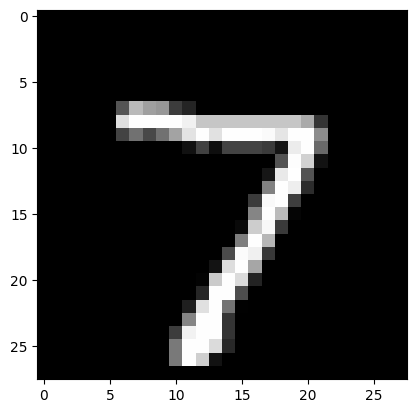

In [85]:
d = next(enumerate(test_loader))[1][0]
reconstructed = model(d.view(-1, 28 *28))
display_tensor(d.view(28,28))


tensor(16)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.5205, 1.7814, 1.3869, 1.5020,
         0.0000, 0.0000, 0.0000, 0.6847, 0.0000, 0.0000, 1.0433, 0.0000, 0.0000,
         1.6884, 0.0000, 0.8677, 0.0000, 0.0000, 0.0358, 0.1573, 0.4990, 0.4255,
         0.0000, 0.9839, 1.1741, 0.5621, 2.5258]], grad_fn=<ReluBackward0>)


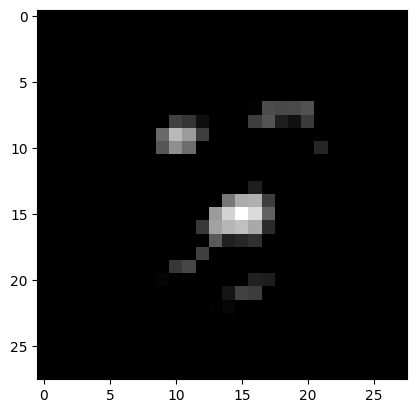

In [125]:
base = model.encode(d.view(-1, 28 *28))

print(torch.count_nonzero(base))

print(base)

delta = torch.zeros(128)


display_tensor(model.decode(torch.rand(32)).view(28, 28).detach())


torch.save(model.state_dict(), 'model-data2.pkl')